In [1]:
import numpy as np
import pandas as pd

from pathlib import Path


In [2]:
rank_path = "../data/processed/ranking_dataset.parquet"
df_rank = pd.read_parquet(rank_path)
df_rank.head()


,user_id,movie_id,label,user_total_ratings,user_avg_rating,user_rating_std,movie_popularity,movie_avg_rating,svd_score
0,1,172,1,271,3.619926,1.255879,366,4.204918,4.411927
1,1,1194,0,271,3.619926,1.255879,31,4.064516,1.331503
2,1,397,0,271,3.619926,1.255879,12,2.583333,0.029563
3,1,1361,0,271,3.619926,1.255879,3,2.666667,0.003841
4,1,168,1,271,3.619926,1.255879,314,4.066879,3.956445


Basic Cleaning & Feature Selection

In [3]:
#Handle missing values
df_rank["user_rating_std"] = df_rank["user_rating_std"].fillna(0.0)
df_rank["movie_avg_rating"] = df_rank["movie_avg_rating"].fillna(df_rank["movie_avg_rating"].mean())
#Choose feature columns and target
target_col = "label"

feature_cols = [
    "user_total_ratings",
    "user_avg_rating",
    "user_rating_std",
    "movie_popularity",
    "movie_avg_rating",
    "svd_score",
]

X = df_rank[feature_cols]
y = df_rank[target_col]


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_val.shape


((175664, 6), (43916, 6))

Train LightGBM Classifier

In [5]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[lgb.log_evaluation(0)]  # 0 disables verbose output
)

[LightGBM] [Info] Number of positive: 43916, number of negative: 131748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1483
[LightGBM] [Info] Number of data points in the train set: 175664, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Quick Evaluation (AUC + Feature Importance)

In [6]:
from sklearn.metrics import roc_auc_score

val_pred_proba = lgbm.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, val_pred_proba)
auc
print(f"Validation AUC: {auc:.4f}")


Validation AUC: 0.9869


Feature Importance

svd_score 2030
movie_popularity 1938
user_total_ratings 1580
movie_avg_rating 1370
user_avg_rating 1181
user_rating_std 901


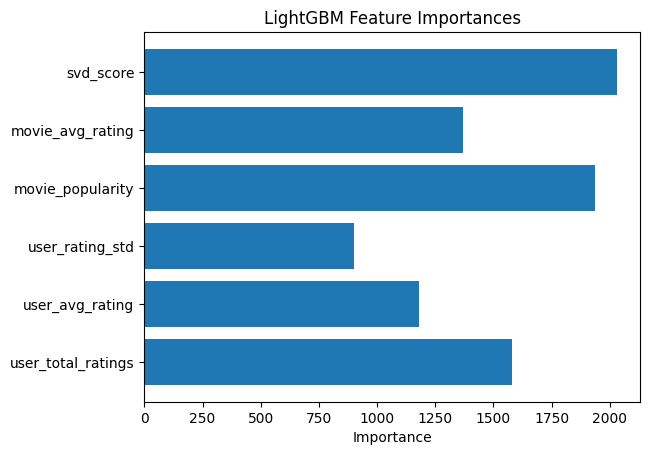

In [7]:
import matplotlib.pyplot as plt

importances = lgbm.feature_importances_
for col, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1]):
    print(col, imp)
plt.barh(feature_cols, importances)
plt.xlabel("Importance")
plt.title("LightGBM Feature Importances")
plt.show()


Save Model with joblib

In [8]:
import joblib

model_path = "../models/lgbm_ranker.pkl"
joblib.dump(lgbm, model_path)
model_path


'../models/lgbm_ranker.pkl'

In [9]:
from recommender.ranker import score_candidates

sample = X_val.head(5)
scores = score_candidates(sample)
scores


array([9.99615407e-01, 1.97510320e-01, 8.53175570e-02, 1.49561186e-04,
       4.06638675e-02])